In [1]:
import numpy as np
import scipy as sp
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.svm import SVC

### Settings

$y_i = \pm 1$,
$\quad \boldsymbol{x}_{i} \,|\, y_i \sim \mathcal{N}( y_i \boldsymbol\mu, \mathbf I_d)$,
$\quad \boldsymbol\mu = \mu \mathbf{e}_1
= (\mu, 0, \cdots, 0)^\top$.

Assume $\mu$ is a fixed constant.

In [2]:
class InfeasibleError(Exception):
   """ Infeasible Problem """
   pass

def sim_data(n, d, pi, mu, sig1=1, sig0=1):
    """ Generate Gaussian Mixture Data """
    n1 = int(np.ceil(n * pi))
    n0 = n - n1
    mu1 = np.append(mu, np.zeros(d-1))
    mu0 = -mu1
    Sig1 = sig1*np.identity(d)
    Sig0 = sig0*np.identity(d)
    X1 = np.random.multivariate_normal(mean=mu1, cov=Sig1, size=n1)
    X0 = np.random.multivariate_normal(mean=mu0, cov=Sig0, size=n0)
    X = np.vstack([X1, X0])
    y = np.repeat([1, 0], [n1, n0])
    return [X, y]

def SVM(X, y, C=1, shrinking=True, tol=1e-8, class_weight=None, standard=True):
    clf = SVC(C=C, kernel='linear', shrinking=shrinking, tol=tol, class_weight=class_weight)
    clf.fit(X, y)
    beta = clf.coef_[0]
    beta0 = clf.intercept_[0]
    kappa = 1
    if standard:
        beta_norm = np.linalg.norm(beta)
        beta, beta0, kappa = beta/beta_norm, beta0/beta_norm, kappa/beta_norm
    return [clf, beta, beta0, kappa]

### Logit distribution

Logit is defined as $\widehat{f}(\boldsymbol{x}_i) = \langle \boldsymbol{x}_i, \widehat{\boldsymbol{\beta}} \rangle + \widehat\beta_0$.

#### Separable regime

The dataset is linear separable (with high probability), i.e., $\kappa^* > 0$.

- $ y_i \widehat{f}(\boldsymbol{x}_i) > 0 $ for all $i$.

Let
- $\widehat\nu_n = \displaystyle\frac1n \sum_{i=1}^n \delta_{(y_i, \widehat{f}(\boldsymbol{x}_i))}$.
- $\nu_* = \texttt{Law}\left( Y, Y \max\{ \kappa^*, \rho^* \|\boldsymbol{\mu}\|_2 + G + Y \beta_0^* \} \right)$.

Then
$ W_2 \left(  \widehat\nu_n , \nu_* \right) \to 0$.

In [3]:
def get_model(pi, n, d, mu, terminate=False):
    X_train, y_train = sim_data(n=n, d=d, pi=pi, mu=mu)
    md, beta, beta0, kappa = SVM(X_train, y_train, C=1)
    # Check linear separability
    if np.mean(md.predict(X_train) == y_train) < 1:
        if terminate:
            raise InfeasibleError(f'Training data is not separable for pi = {pi:.3f}.')
        else:
            print(f'Training data is not separable for pi = {pi:.3f}.')
    # two support vectors in each class
    idx_SV = np.array([np.where(y_train[md.support_] == 1)[0][0],
                       np.where(y_train[md.support_] == 0)[0][0]])
    SV2 = md.support_vectors_[idx_SV, :]
    return [[X_train, y_train], md, beta, beta0, kappa, SV2]

#### Auxiliary functions

Define
$ \displaystyle g_k(x) = \mathbb{E}[(G+x)_+^k] = \int_{-x}^\infty (t+x)^k \phi(t) \, \mathrm{d} t$.

By direct calculation ([reference](https://en.wikipedia.org/wiki/List_of_integrals_of_Gaussian_functions))

$$ g_1(x) = x \Phi(x) + \phi(x), \qquad g_2(x) = (x^2+1)\Phi(x) + x\phi(x). $$

In [4]:
from pynverse import inversefunc

def g_1(x):
    return x * norm.cdf(x) + norm.pdf(x)

def g_2(x):
    return (x**2 + 1) * norm.cdf(x) + x * norm.pdf(x)

def g(x):
    return g_2(inversefunc(g_1, x))

def g_1_inv(x):
    return inversefunc(g_1, x)

In [5]:
def gordon_eq_sys(theta, args):
    rho, beta0, kappa = theta
    pi, delta, mu, tau = args
    z1 = -rho * mu - beta0 + kappa * tau
    z2 = -rho * mu + beta0 + kappa
    eq1 = g_1(z1) - rho/(2 * pi * mu * delta)
    eq2 = g_1(z2) - rho/(2 * (1-pi) * mu * delta)
    eq3 = pi * delta * g_2(z1) + (1-pi) * delta * g_2(z2) - 1 + rho**2
    return eq1, eq2, eq3

def solve_gordon_eq(pi, mu, n=None, d=None, delta=None, tau=1):
    if delta is None:
        delta = n/d
    args = (pi, delta, mu, tau)
    return sp.optimize.fsolve(lambda theta: gordon_eq_sys(theta, args=args), np.zeros(3))

Plot for logit distribution (ELD and TLD).

In [6]:
def logit_plot_sep(pi, n, d, mu, fig_size, binwidth, seed=2023, save=False,
                   save_dir=''):
    # solve gordon equations
    rho, beta0, kappa = solve_gordon_eq(pi=pi, n=n, d=d, mu=mu, tau=1)
    if kappa < 0:
        raise InfeasibleError(f'Underparametrized regime.')
    np.random.seed(seed)
    data_train, md, beta, beta0, kappa, SV2 = get_model(pi=pi, n=n, d=d, mu=mu, terminate=True)
    X, y = data_train
    logit_sign = X @ beta + beta0
    logit1 = logit_sign[np.where(y == 1)]
    logit0 = logit_sign[np.where(y == 0)]

    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
    with plt.style.context('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle'):
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=fig_size, dpi=100, constrained_layout=True)
        fig.suptitle(r'\textbf{{Logit Distribution}}', fontweight='bold')
        cols = ['#5A5B9F', '#D94F70', '#009473', '#F0C05A', '#7BC4C4', '#FF6F61']
        bins1 = np.arange(min(logit1), max(logit1) + binwidth, binwidth)
        bins0 = np.arange(min(logit0), max(logit0) + binwidth, binwidth)
        axs.hist(logit1, density=True, bins=bins1, edgecolor=None, alpha=0.30, color=cols[0],
                 label=r'Minority ELD')
        axs.hist(logit0, density=True, bins=bins0, edgecolor=None, alpha=0.40, color=cols[3],
                 label=r'Majority ELD')

        # theoretical density for empirical logits
        def get_density(xmin, xmax, loc, **kwargs):
            xx = np.linspace(xmin, xmax, 1000)
            axs.plot(xx, norm.pdf(xx, loc=loc), **kwargs)
            return None

        get_density(xmin=kappa, xmax=np.max(logit1), loc=rho*mu+beta0,
                    label='Minority TLD', color=cols[0])
        get_density(xmin=np.min(logit0), xmax=kappa, loc=rho*mu+beta0, linestyle=':', color=cols[0])
        get_density(xmin=np.min(logit0), xmax=-kappa, loc=-rho*mu+beta0,
                    label='Majority TLD', color=cols[3])
        get_density(xmin=-kappa, xmax=np.max(logit1), loc=-rho*mu+beta0, linestyle=':', color=cols[3])

        # decision boundary
        axs.axvline(x=0, color='red', linestyle='--', label='Decision boundary')
        axs.legend()
        axs.set_xlabel(r'logit')
        axs.set_ylim(0, 0.8)
        arrow_h = 0.5
        axs.annotate(text='', xy=( kappa, arrow_h), xytext=(0, arrow_h),
                     arrowprops=dict(arrowstyle='<->', shrinkA=0, shrinkB=0))
        axs.annotate(text='', xy=(-kappa, arrow_h), xytext=(0, arrow_h),
                     arrowprops=dict(arrowstyle='<->', shrinkA=0, shrinkB=0))
        axs.annotate(text='margin', xy=(0, arrow_h), xytext=(kappa/2, arrow_h + 0.03),
                     ha='center', va='center')
    if save:
        plt.savefig(save_dir + f'sep_ pi = {pi}, mu = {mu}, n = {n}, d = {d}.pdf')
    else:
        plt.show()
    return None

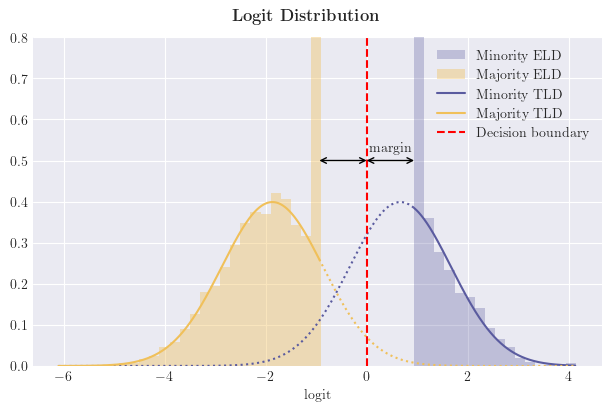

In [7]:
logit_plot_sep(pi=0.15, n=2000*5, d=800*5, mu=1.75, fig_size=(6, 4), binwidth=0.2, save=True, seed=2023)